In [86]:
import sys
from pathlib import Path

# Get the folder where this notebook is running
notebook_path = Path().resolve()

# Assume 'src' is at the project root, one level up from the notebook folder
project_root = notebook_path.parent

# Construct the full path to src
src_path = project_root / "src"

# Add src to sys.path if not already there
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))

print(f"Added {src_path} to sys.path")

Added /home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/src to sys.path


In [87]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    average_precision_score
)

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import numpy as np
import seaborn as sns


# Configuration

In [88]:
plt.style.use('ggplot')

random_seed = 42

#set output of skllearn to be a pandas dataframe
set_config(transform_output = "pandas")


# Load Data

In [89]:
#train data
x_train = pd.read_csv('../data/cleaned/train/x_train_cleaned.csv')
x_train_discount = pd.read_csv('../data/cleaned/train/x_train_cleaned_discount.csv')
y_train = pd.read_csv('../data/cleaned/train/y_train.csv')


#test data
x_test  = pd.read_csv('../data/cleaned/test/x_test_cleaned.csv')
x_test_discount  = pd.read_csv('../data/cleaned/test/x_test_cleaned_discount.csv')
y_test  = pd.read_csv('../data/cleaned/test/y_test.csv')



# Train Test Split

In [90]:
#20 % of the data is used for validation
y_train_original = y_train.copy()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, 
                                random_state = random_seed,
                                stratify = y_train)



In [91]:
x_train_discount, x_val_discount = train_test_split(x_train_discount, test_size = 0.2, 
                                random_state = random_seed,
                                stratify = y_train_original)



# Models


In [92]:
def calculating_metrics(y_true, y_pred, y_pred_proba,
                         model_name,
                         print_results = True):
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    if print_results:
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"ROC AUC:   {roc_auc:.4f}")

        print("\nClassification Report:\n")
        print(classification_report(y_val, y_pred))

    results = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }

    results = pd.DataFrame.from_dict(results, orient = 'index')
    results.columns = [model_name]

    return results

In [93]:
def plot_precision_recall_curve(y_true, y_pred_proba):   
    
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    avg_precision = average_precision_score(y_val, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## LightGBM

In [94]:
model_lgbm_no_sampling = LGBMClassifier(
    class_weight = 'balanced', 
    scale_pos_weight = 9.0, 
    n_estimators = 100,
    random_state = 42
)
model_lgbm_no_sampling.fit(x_train, y_train)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 908, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8501
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42, scale_pos_weight=9.0)

In [95]:
y_pred = model_lgbm_no_sampling.predict(x_val)
y_pred_proba = model_lgbm_no_sampling.predict_proba(x_val)[:, 1]  # For AUC

lgbm_no_sampling = calculating_metrics(y_val, y_pred, y_pred_proba, 'lgbm_no_sampling')





Accuracy:  0.5541
Precision: 0.1435
Recall:    0.7225
F1 Score:  0.2394
ROC AUC:   0.6659

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.54      0.68      2110
           1       0.14      0.72      0.24       227

    accuracy                           0.55      2337
   macro avg       0.55      0.63      0.46      2337
weighted avg       0.87      0.55      0.64      2337



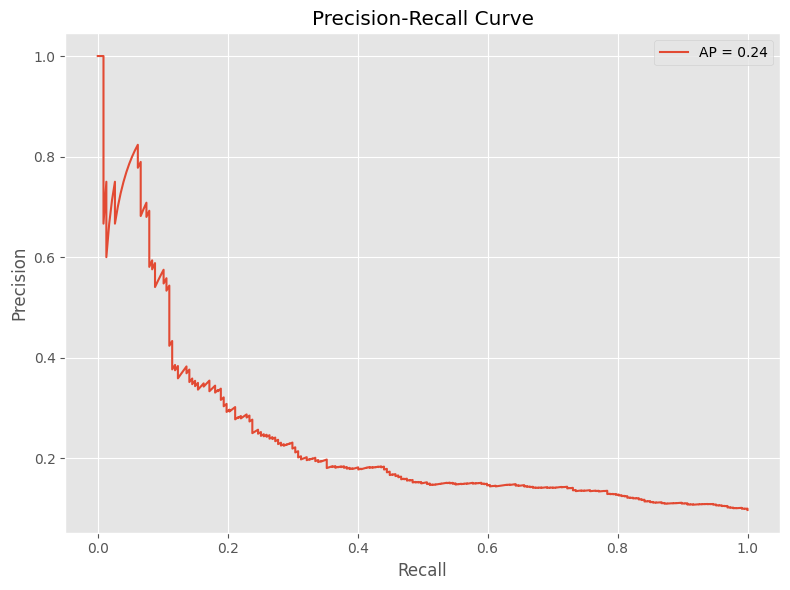

In [96]:
plot_precision_recall_curve(y_val, y_pred_proba)

### Feature Importance

In [97]:
split_importance = model_lgbm_no_sampling.feature_importances_
gain_importance  = model_lgbm_no_sampling.booster_.feature_importance(importance_type = 'gain')

feature_importance = pd.DataFrame({
    "feature": x_train.columns,
    "split_importance": split_importance,
    "gain_importance": gain_importance
}).sort_values("gain_importance", ascending=False)

print(feature_importance.head(10))


                      feature  split_importance  gain_importance
6     forecast_meter_rent_12m               256      8191.892935
11       margin_gross_pow_ele               204      6791.207086
0                    cons_12m               184      5743.766969
3           forecast_cons_12m               129      4686.927815
18             days_until_end               149      4673.436491
19    days_since_modification               152      4611.390508
14                 net_margin               136      4319.234066
29  energy_peak_minus_offpeak               117      4073.718806
17            contract_length               104      4032.973643
49     std_price_off_peak_var                99      3464.903262


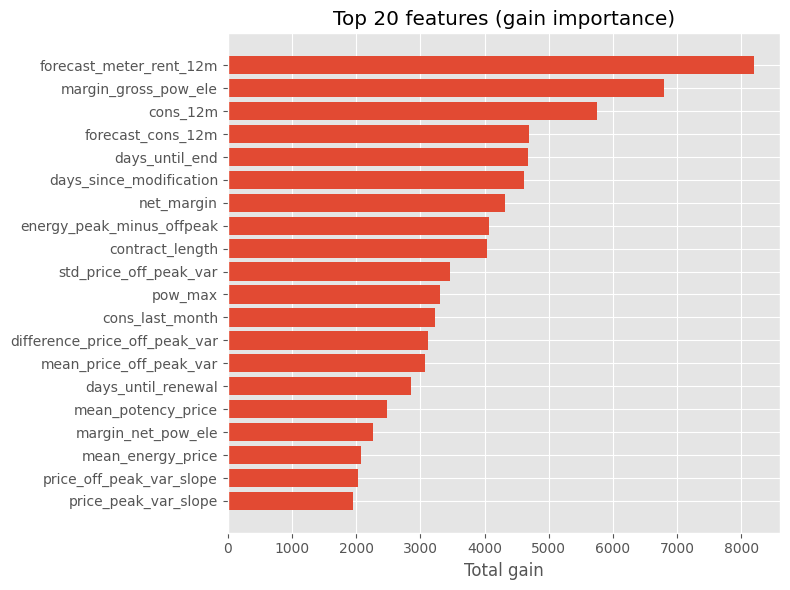

In [98]:
top_k = 20
feature_importance_top = feature_importance.head(top_k).iloc[::-1]        # reverse for horizontal bar

plt.figure(figsize=(8, 6))
plt.barh(feature_importance_top["feature"], feature_importance_top["gain_importance"])
plt.title(f"Top {top_k} features (gain importance)")
plt.xlabel("Total gain")
plt.tight_layout()
plt.show()

## Logistic Regression

In [99]:
clf = LogisticRegression(random_state = random_seed,
                        max_iter = 1000, 
                        class_weight = 'balanced')
clf.fit(x_train, y_train)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [100]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_no_sampling = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_no_sampling')




Accuracy:  0.6119
Precision: 0.1451
Recall:    0.6123
F1 Score:  0.2346
ROC AUC:   0.6576

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.61      0.74      2110
           1       0.15      0.61      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.61      0.49      2337
weighted avg       0.86      0.61      0.69      2337



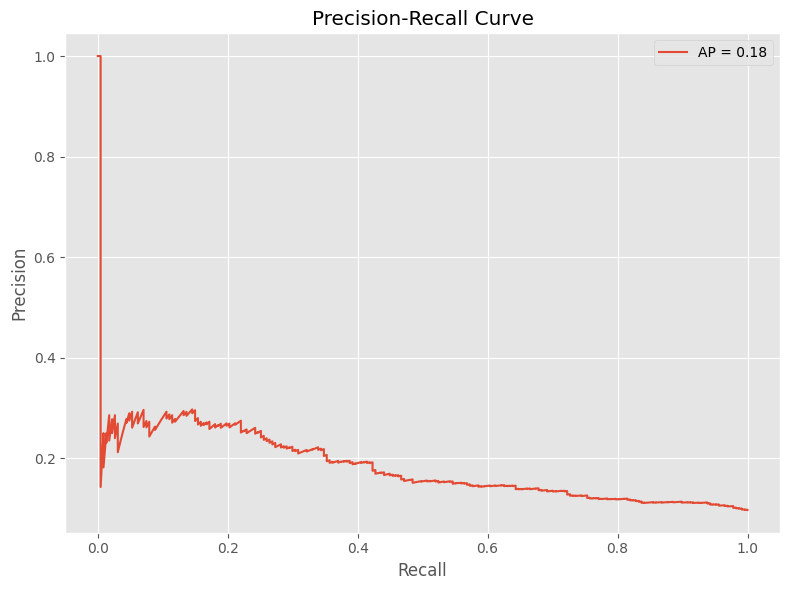

In [101]:
plot_precision_recall_curve(y_val, y_pred_proba)

## Sampling

### Random under-sampling

#### LightGBM

In [102]:
rus = RandomUnderSampler(random_state = random_seed)
x_train_rus_resampled, y_train_rus_resampled = rus.fit_resample(x_train, y_train)

In [103]:
model_lgbm = LGBMClassifier(
    class_weight = 'balanced', 
    n_estimators = 100,
    random_state = 42
)
model_lgbm.fit(x_train_rus_resampled, y_train_rus_resampled)


[LightGBM] [Info] Number of positive: 908, number of negative: 908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7404
[LightGBM] [Info] Number of data points in the train set: 1816, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(class_weight='balanced', random_state=42)

In [104]:
y_pred = model_lgbm.predict(x_val)
y_pred_proba = model_lgbm.predict_proba(x_val)[:, 1]  # For AUC

lgbm_rus = calculating_metrics(y_val, y_pred, y_pred_proba, 'lgbm_rus')


Accuracy:  0.6153
Precision: 0.1364
Recall:    0.5551
F1 Score:  0.2189
ROC AUC:   0.6327

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.62      0.74      2110
           1       0.14      0.56      0.22       227

    accuracy                           0.62      2337
   macro avg       0.53      0.59      0.48      2337
weighted avg       0.85      0.62      0.69      2337



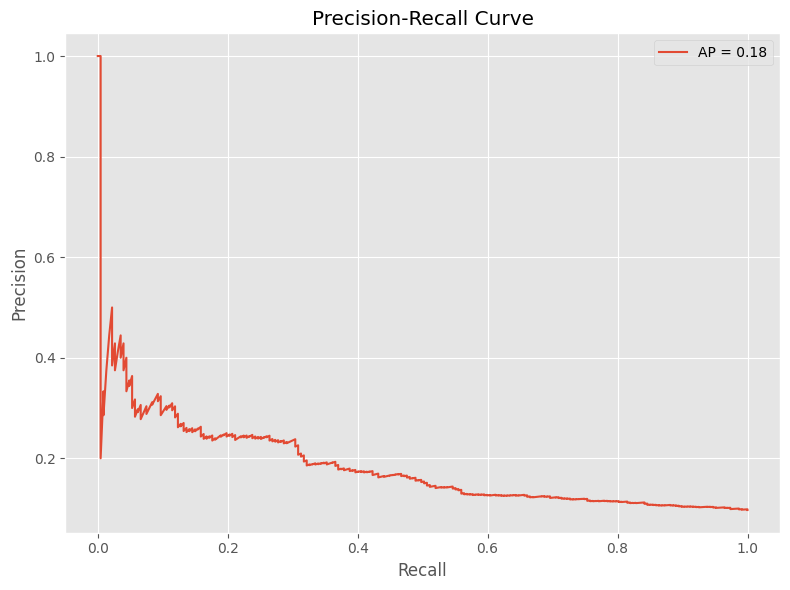

In [105]:
plot_precision_recall_curve(y_val, y_pred_proba)

#### Logistic Regression

In [106]:
clf.fit(x_train_rus_resampled, y_train_rus_resampled)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [107]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_rus = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_rus')


Accuracy:  0.6093
Precision: 0.1412
Recall:    0.5947
F1 Score:  0.2282
ROC AUC:   0.6474

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.60      0.48      2337
weighted avg       0.86      0.61      0.69      2337



### Smote

In [108]:
x_train_smote, y_train_smote = SMOTE(random_state = random_seed).fit_resample(x_train, y_train)


##### LightGBM

In [109]:
model_lgbm.fit(x_train_smote, y_train_smote)


[LightGBM] [Info] Number of positive: 8439, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13027
[LightGBM] [Info] Number of data points in the train set: 16878, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(class_weight='balanced', random_state=42)

In [110]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

lgbm_smote = calculating_metrics(y_val, y_pred, y_pred_proba, 'lightgbm_smote')


Accuracy:  0.6093
Precision: 0.1412
Recall:    0.5947
F1 Score:  0.2282
ROC AUC:   0.6474

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.60      0.48      2337
weighted avg       0.86      0.61      0.69      2337



#### Logistic Regression

In [111]:
clf.fit(x_train_smote, y_train_smote)

/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [112]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_smote = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_rus')

Accuracy:  0.6175
Precision: 0.1426
Recall:    0.5859
F1 Score:  0.2293
ROC AUC:   0.6536

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.62      0.75      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.62      2337
   macro avg       0.54      0.60      0.49      2337
weighted avg       0.86      0.62      0.70      2337



## Feature Selection

Model-based feature importance

In [113]:
selector = SelectFromModel(model_lgbm_no_sampling, threshold="median", prefit=True)
x_train_selected = selector.transform(x_train)
x_val_selected = selector.transform(x_val)
x_test_selected = selector.transform(x_test)

/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [114]:
model_selected_no_sampling = LGBMClassifier(
    class_weight = 'balanced', 
    n_estimators = 100,
    random_state = 42
)

model_selected_no_sampling.fit(x_train_selected, y_train)

[LightGBM] [Info] Number of positive: 908, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7765
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(class_weight='balanced', random_state=42)

In [115]:
y_pred = model_selected_no_sampling.predict(x_val_selected)
y_pred_proba = model_selected_no_sampling.predict_proba(x_val_selected)[:, 1]  # For AUC
lgbm_no_sampling_selected = calculating_metrics(y_val, y_pred, y_pred_proba, 'lightgbm_ns_selected')

Accuracy:  0.8280
Precision: 0.2388
Recall:    0.3524
F1 Score:  0.2847
ROC AUC:   0.6733

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      2110
           1       0.24      0.35      0.28       227

    accuracy                           0.83      2337
   macro avg       0.58      0.62      0.59      2337
weighted avg       0.86      0.83      0.84      2337



## Results - Comparisson

In [116]:
results = pd.concat([lgbm_no_sampling, lgbm_rus, lgbm_smote, lgbm_no_sampling_selected, 
                logistic_no_sampling, logistic_rus, logistic_smote], axis = 1)

In [117]:
results

,lgbm_no_sampling,lgbm_rus,lightgbm_smote,lightgbm_ns_selected,logistic_no_sampling,logistic_rus,logistic_rus
accuracy,0.554129,0.615319,0.609328,0.827985,0.611896,0.609328,0.617458
precision,0.143482,0.136364,0.141213,0.238806,0.145094,0.141213,0.142551
recall,0.722467,0.555066,0.594714,0.352423,0.612335,0.594714,0.585903
f1,0.239416,0.218940,0.228233,0.284698,0.234599,0.228233,0.229310
roc_auc,0.665929,0.632729,0.647366,0.673339,0.657607,0.647366,0.653555


## Causal

In [118]:
y_pred_proba = model_lgbm_no_sampling.predict_proba(x_val)
y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['prob_not_churned', 'prob_churned'])
y_pred_proba = pd.concat([y_pred_proba, y_val.reset_index(drop = True)], axis = 1)
y_pred_proba

,prob_not_churned,prob_churned,churn
0,0.379140,0.620860,0
1,0.693348,0.306652,1
2,0.777551,0.222449,0
3,0.132555,0.867445,0
4,0.892188,0.107812,0
...,...,...,...
2332,0.786379,0.213621,0
2333,0.832798,0.167202,0
2334,0.797371,0.202629,0
2335,0.857587,0.142413,0


In [119]:
churned_no_discount = y_pred_proba[y_pred_proba['churn'] == 1]

n_churned = len(churned_no_discount)
n_correct_preds = len(churned_no_discount[churned_no_discount['prob_churned'] > 0.5])

print('Number of churned no discount:', n_churned)
print('Number of correct predictions no discount:', n_correct_preds)
print(f'Proportion: {100*n_correct_preds/n_churned:.2f}%')



Number of churned no discount: 227
Number of correct predictions no discount: 164
Proportion: 72.25%


In [120]:
samples = np.arange(1, n_churned + 1)

Text(0.5, 0, 'Sample')

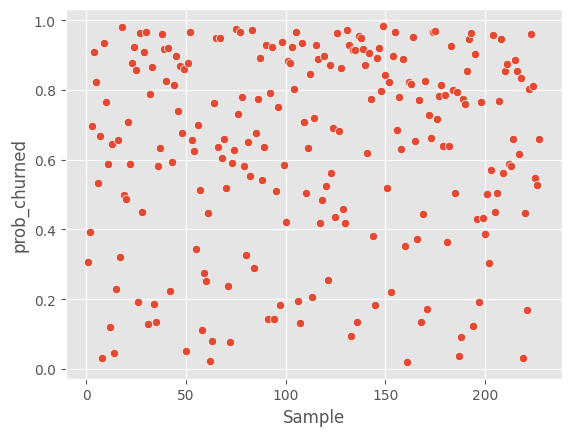

In [121]:
sns.scatterplot(x = samples, y = churned_no_discount['prob_churned'])
plt.xlabel('Sample')


In [122]:
y_pred_proba_discount = model_lgbm_no_sampling.predict_proba(x_val_discount)
y_pred_proba_discount = pd.DataFrame(y_pred_proba_discount, columns = ['prob_not_churned_discount', 'prob_churned_discount'])
y_pred_proba_discount = pd.concat([y_pred_proba_discount, y_val.reset_index(drop = True)], axis = 1)
y_pred_proba_discount

,prob_not_churned_discount,prob_churned_discount,churn
0,0.486703,0.513297,0
1,0.833195,0.166805,1
2,0.953087,0.046913,0
3,0.512775,0.487225,0
4,0.943044,0.056956,0
...,...,...,...
2332,0.638672,0.361328,0
2333,0.836168,0.163832,0
2334,0.701837,0.298163,0
2335,0.576849,0.423151,0


In [123]:
churned_discount = y_pred_proba_discount[y_pred_proba_discount['churn'] == 1]
n_pred_chrurned_discount = len(churned_discount[churned_discount['prob_churned_discount'] > 0.5])

print('Number of churned predictions:', n_pred_chrurned_discount)

Number of churned predictions: 108


Text(0.5, 0, 'Sample')

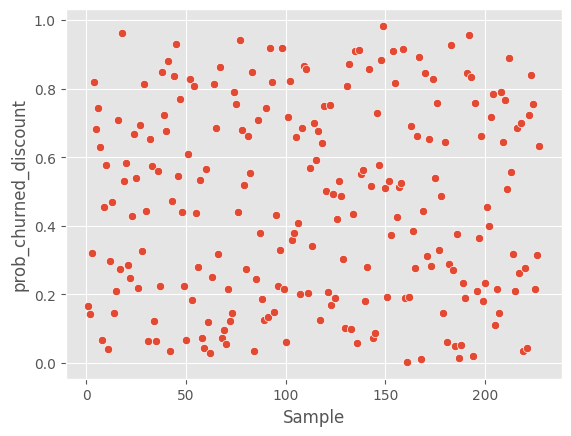

In [124]:
sns.scatterplot(x = samples, y = churned_discount['prob_churned_discount'])
plt.xlabel('Sample')

Text(0, 0.5, 'Predicted probability')

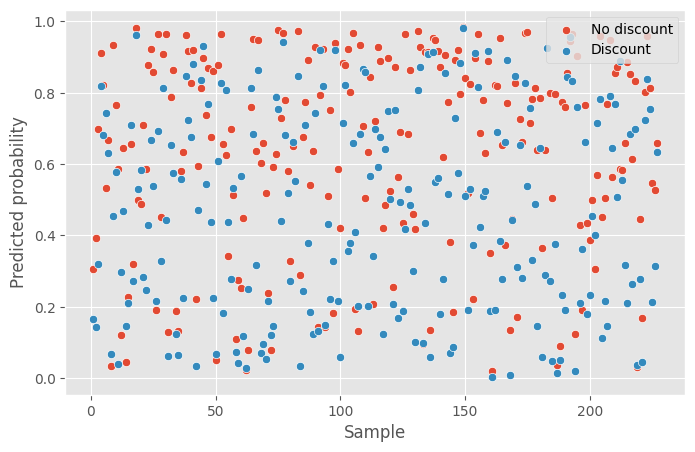

In [125]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x = samples, y = churned_no_discount['prob_churned'], label = 'No discount')
sns.scatterplot(x = samples, y = churned_discount['prob_churned_discount'], label = 'Discount')
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Predicted probability')


In [126]:
comparison = pd.concat([churned_no_discount, churned_discount], axis = 1)
comparison = comparison.loc[comparison['prob_churned'] > 0.5, ['prob_churned', 'prob_churned_discount']]

In [127]:
comparison

,prob_churned,prob_churned_discount
13,0.697626,0.320759
25,0.910397,0.818408
31,0.822454,0.682777
49,0.532214,0.742705
61,0.668015,0.630127
...,...,...
2283,0.960498,0.838814
2290,0.812317,0.754455
2302,0.548235,0.214441
2315,0.527566,0.313243


In [128]:
samples = np.arange(1, len(comparison) + 1)

Text(0, 0.5, 'Predicted probability')

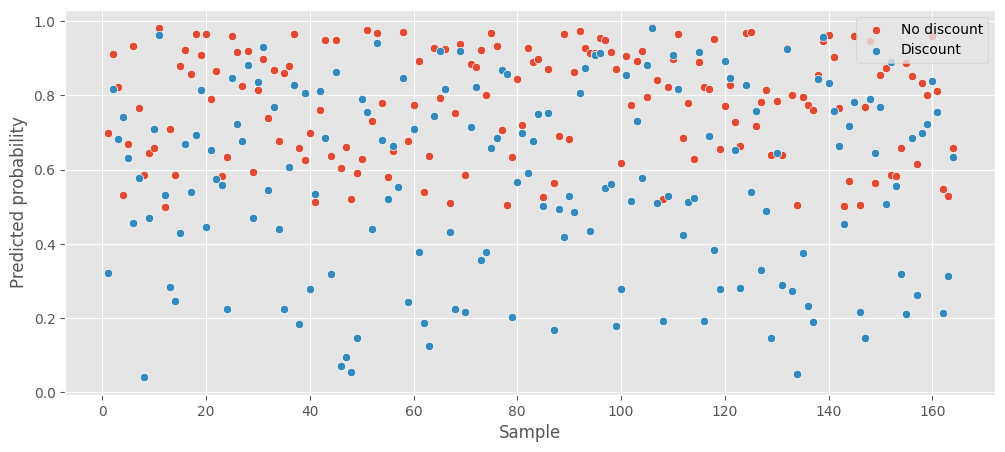

In [129]:
plt.figure(figsize=(12, 5))

sns.scatterplot(x = samples, y = comparison['prob_churned'], label = 'No discount')
sns.scatterplot(x = samples, y = comparison['prob_churned_discount'], label = 'Discount')
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Predicted probability')

In [130]:
comparison['difference'] = comparison['prob_churned'] - comparison['prob_churned_discount']

In [131]:
len(comparison)

164

In [132]:
len(comparison[comparison['difference'] > 0])

140